## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 12 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp007'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 12 # 6
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([12, 224, 224])

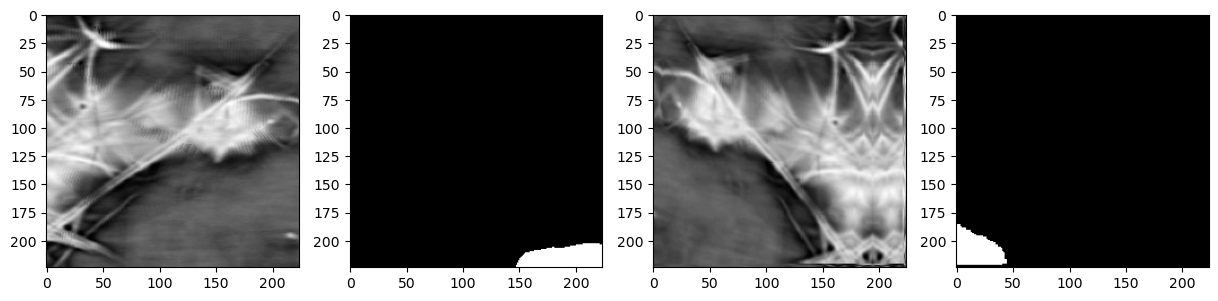

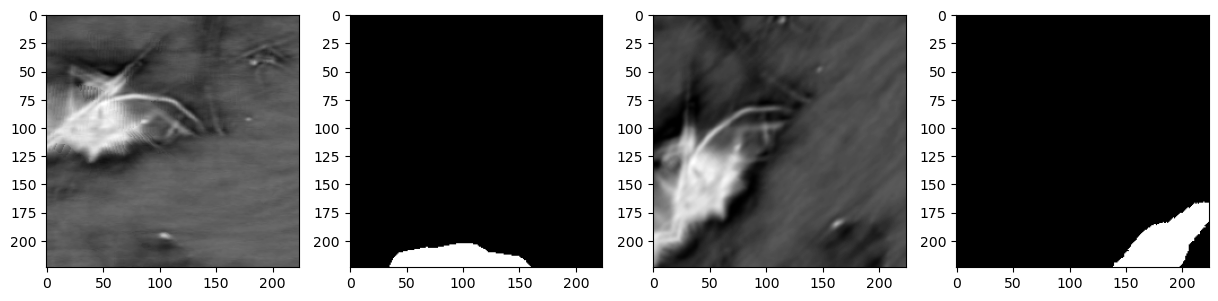

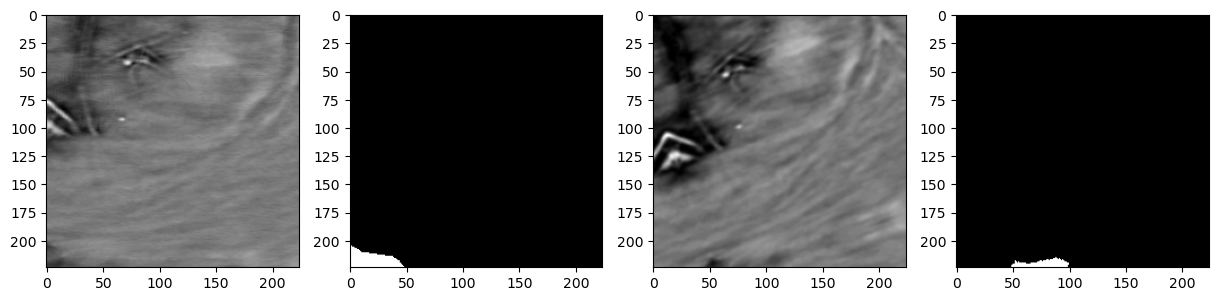

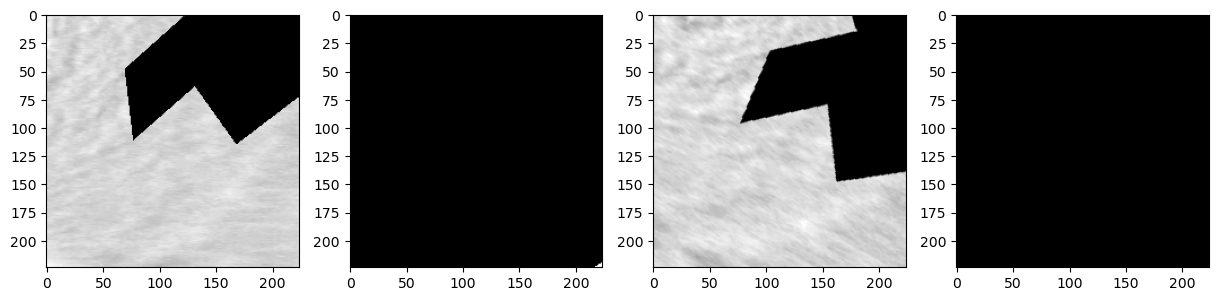

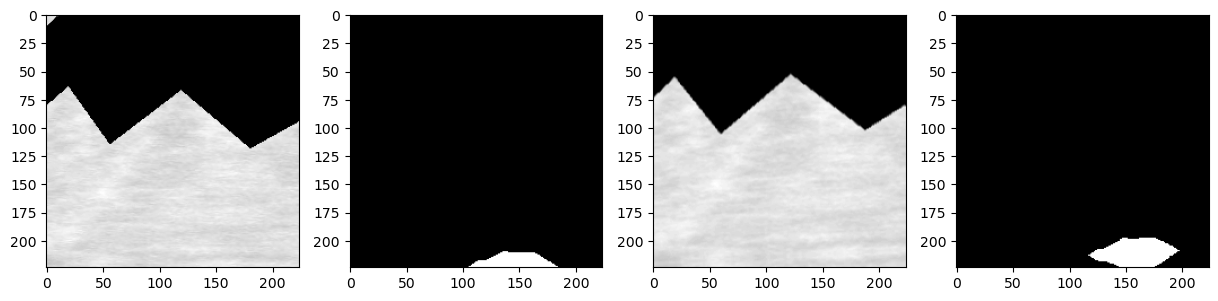

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48125

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.16109306659562067
th: 0.15, fbeta: 0.22229858023206736
th: 0.2, fbeta: 0.23910087643158376
th: 0.25, fbeta: 0.25448250327278704
th: 0.3, fbeta: 0.2763876474458116
th: 0.35, fbeta: 0.30655174352475284
th: 0.4, fbeta: 0.33764101175407046
th: 0.45, fbeta: 0.34801146053802484


best_th: 0.45, fbeta: 0.34801146053802484
Epoch 1 - avg_train_loss: 0.4037  avg_val_loss: 0.3344  time: 232s
Epoch 1 - avgScore: 0.3480
Epoch 1 - Save Best Score: 0.3480 Model
Epoch 1 - Save Best Loss: 0.3344 Model


th: 0.5, fbeta: 0.2964561271015979


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22973761500560258
th: 0.15, fbeta: 0.25095337348148244
th: 0.2, fbeta: 0.27538501100204726
th: 0.25, fbeta: 0.3065783838495469
th: 0.3, fbeta: 0.3445533709899879
th: 0.35, fbeta: 0.3797591463324232
th: 0.4, fbeta: 0.4061456042119422
th: 0.45, fbeta: 0.41822310165595683


best_th: 0.45, fbeta: 0.41822310165595683
Epoch 2 - avg_train_loss: 0.3141  avg_val_loss: 0.2881  time: 231s
Epoch 2 - avgScore: 0.4182
Epoch 2 - Save Best Score: 0.4182 Model
Epoch 2 - Save Best Loss: 0.2881 Model


th: 0.5, fbeta: 0.3986409441513849


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.26535660795417126
th: 0.15, fbeta: 0.2983360753627296
th: 0.2, fbeta: 0.34306945175444625
th: 0.25, fbeta: 0.3957964213673181
th: 0.3, fbeta: 0.42130958417900977
th: 0.35, fbeta: 0.4399244166696569
th: 0.4, fbeta: 0.4550890218447828
th: 0.45, fbeta: 0.46304360207150735


best_th: 0.45, fbeta: 0.46304360207150735
Epoch 3 - avg_train_loss: 0.2675  avg_val_loss: 0.2376  time: 232s
Epoch 3 - avgScore: 0.4630
Epoch 3 - Save Best Score: 0.4630 Model
Epoch 3 - Save Best Loss: 0.2376 Model


th: 0.5, fbeta: 0.4603703941338804


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32915558457743616
th: 0.15, fbeta: 0.3653920603058052
th: 0.2, fbeta: 0.3893145102977599
th: 0.25, fbeta: 0.40871393904439807
th: 0.3, fbeta: 0.42674353326714326
th: 0.35, fbeta: 0.44481789505735303
th: 0.4, fbeta: 0.45675845701872925
th: 0.45, fbeta: 0.4631409482358386


best_th: 0.5, fbeta: 0.46394420182264423
Epoch 4 - avg_train_loss: 0.2417  avg_val_loss: 0.2415  time: 232s
Epoch 4 - avgScore: 0.4639
Epoch 4 - Save Best Score: 0.4639 Model
Epoch 4 - Save Best Loss: 0.2415 Model


th: 0.5, fbeta: 0.46394420182264423


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.289227623918344
th: 0.15, fbeta: 0.3271658065740181
th: 0.2, fbeta: 0.380615149460847
th: 0.25, fbeta: 0.42014337297978205
th: 0.3, fbeta: 0.4423790001403492
th: 0.35, fbeta: 0.45579056752928376
th: 0.4, fbeta: 0.4671372385850408
th: 0.45, fbeta: 0.4693672423827278


best_th: 0.45, fbeta: 0.4693672423827278
Epoch 5 - avg_train_loss: 0.2279  avg_val_loss: 0.2366  time: 230s
Epoch 5 - avgScore: 0.4694
Epoch 5 - Save Best Score: 0.4694 Model
Epoch 5 - Save Best Loss: 0.2366 Model


th: 0.5, fbeta: 0.46693230522335955


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39369616387404544
th: 0.15, fbeta: 0.4492570052822876
th: 0.2, fbeta: 0.4803426292486683
th: 0.25, fbeta: 0.501985887576472
th: 0.3, fbeta: 0.514729085006889
th: 0.35, fbeta: 0.5223631655930115
th: 0.4, fbeta: 0.5227873983900067
th: 0.45, fbeta: 0.5168513515983733


best_th: 0.4, fbeta: 0.5227873983900067
Epoch 6 - avg_train_loss: 0.2169  avg_val_loss: 0.2417  time: 231s
Epoch 6 - avgScore: 0.5228
Epoch 6 - Save Best Score: 0.5228 Model
Epoch 6 - Save Best Loss: 0.2417 Model


th: 0.5, fbeta: 0.501645019359157


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3590227087435091
th: 0.15, fbeta: 0.3948494912242411
th: 0.2, fbeta: 0.42449886390669583
th: 0.25, fbeta: 0.4499393231656795
th: 0.3, fbeta: 0.46724516451351034
th: 0.35, fbeta: 0.4764058539434381
th: 0.4, fbeta: 0.4824679139620305
th: 0.45, fbeta: 0.4864086099100673


best_th: 0.45, fbeta: 0.4864086099100673
Epoch 7 - avg_train_loss: 0.2076  avg_val_loss: 0.2450  time: 230s
Epoch 7 - avgScore: 0.4864


th: 0.5, fbeta: 0.4852773521578129


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3594550347206837
th: 0.15, fbeta: 0.3968890321544252
th: 0.2, fbeta: 0.42585506649197263
th: 0.25, fbeta: 0.4477741925740138
th: 0.3, fbeta: 0.46336951142718386
th: 0.35, fbeta: 0.47470420318684103
th: 0.4, fbeta: 0.4777731827637843
th: 0.45, fbeta: 0.47358530483183875


best_th: 0.4, fbeta: 0.4777731827637843
Epoch 8 - avg_train_loss: 0.1923  avg_val_loss: 0.2498  time: 230s
Epoch 8 - avgScore: 0.4778


th: 0.5, fbeta: 0.46320569375253


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4137554245413251
th: 0.15, fbeta: 0.43847752212059565
th: 0.2, fbeta: 0.4540358591417528
th: 0.25, fbeta: 0.46635314454578725
th: 0.3, fbeta: 0.4699825985305501
th: 0.35, fbeta: 0.47240482907149967
th: 0.4, fbeta: 0.4729961128309662
th: 0.45, fbeta: 0.4690169468575896


best_th: 0.4, fbeta: 0.4729961128309662
Epoch 9 - avg_train_loss: 0.1802  avg_val_loss: 0.2761  time: 232s
Epoch 9 - avgScore: 0.4730


th: 0.5, fbeta: 0.46496834521075087


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4281864069878005
th: 0.15, fbeta: 0.4502665296762172
th: 0.2, fbeta: 0.46390513024491586
th: 0.25, fbeta: 0.476580029271125
th: 0.3, fbeta: 0.48418611246735593
th: 0.35, fbeta: 0.48954942417860925
th: 0.4, fbeta: 0.48982087756177095
th: 0.45, fbeta: 0.4830749577876007


best_th: 0.4, fbeta: 0.48982087756177095
Epoch 10 - avg_train_loss: 0.1713  avg_val_loss: 0.2867  time: 229s
Epoch 10 - avgScore: 0.4898


th: 0.5, fbeta: 0.4712503822016568


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41393541734207945
th: 0.15, fbeta: 0.44636768593504167
th: 0.2, fbeta: 0.4688753562374672
th: 0.25, fbeta: 0.4869133453098375
th: 0.3, fbeta: 0.49654316772011164
th: 0.35, fbeta: 0.5003481159702144
th: 0.4, fbeta: 0.5006743976831466
th: 0.45, fbeta: 0.49635861997860037


best_th: 0.4, fbeta: 0.5006743976831466
Epoch 11 - avg_train_loss: 0.1614  avg_val_loss: 0.2785  time: 232s
Epoch 11 - avgScore: 0.5007


th: 0.5, fbeta: 0.48615378224937045


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4165280593940849
th: 0.15, fbeta: 0.4450176926212786
th: 0.2, fbeta: 0.4666535582181905
th: 0.25, fbeta: 0.47627610317600355
th: 0.3, fbeta: 0.4768548268124315
th: 0.35, fbeta: 0.47719727242308346
th: 0.4, fbeta: 0.4742780040769337
th: 0.45, fbeta: 0.46549404285068957


best_th: 0.35, fbeta: 0.47719727242308346
Epoch 12 - avg_train_loss: 0.1503  avg_val_loss: 0.2942  time: 230s
Epoch 12 - avgScore: 0.4772


th: 0.5, fbeta: 0.450280261917059


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3819174180661427
th: 0.15, fbeta: 0.411721329724432
th: 0.2, fbeta: 0.43638114762993535
th: 0.25, fbeta: 0.4593615876275357
th: 0.3, fbeta: 0.4766582107661004
th: 0.35, fbeta: 0.486477846347864
th: 0.4, fbeta: 0.4929291287410553
th: 0.45, fbeta: 0.49488873008653894


best_th: 0.45, fbeta: 0.49488873008653894
Epoch 13 - avg_train_loss: 0.1400  avg_val_loss: 0.2825  time: 230s
Epoch 13 - avgScore: 0.4949


th: 0.5, fbeta: 0.49150912199161


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3893490270373465
th: 0.15, fbeta: 0.41803839319418
th: 0.2, fbeta: 0.4396274031357807
th: 0.25, fbeta: 0.45475590090759926
th: 0.3, fbeta: 0.47020763692018397
th: 0.35, fbeta: 0.4812378321323905
th: 0.4, fbeta: 0.48475307039714544
th: 0.45, fbeta: 0.47765478837848596


best_th: 0.4, fbeta: 0.48475307039714544
Epoch 14 - avg_train_loss: 0.1325  avg_val_loss: 0.2931  time: 234s
Epoch 14 - avgScore: 0.4848


th: 0.5, fbeta: 0.4674031646464624


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4200356417489893
th: 0.15, fbeta: 0.44441073161272826
th: 0.2, fbeta: 0.46129835904769584
th: 0.25, fbeta: 0.471339083198234
th: 0.3, fbeta: 0.47936173833399776
th: 0.35, fbeta: 0.4855065233759202
th: 0.4, fbeta: 0.48705932827448256
th: 0.45, fbeta: 0.48434863314212134


best_th: 0.4, fbeta: 0.48705932827448256
Epoch 15 - avg_train_loss: 0.1238  avg_val_loss: 0.3393  time: 235s
Epoch 15 - avgScore: 0.4871


th: 0.5, fbeta: 0.4754948989456503


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41186643543247203
th: 0.15, fbeta: 0.445138088290753
th: 0.2, fbeta: 0.4641519249580957
th: 0.25, fbeta: 0.4785225704051969
th: 0.3, fbeta: 0.4864395682115968
th: 0.35, fbeta: 0.48911759846292874
th: 0.4, fbeta: 0.4848172736637813
th: 0.45, fbeta: 0.4790671592180971


best_th: 0.35, fbeta: 0.48911759846292874
Epoch 16 - avg_train_loss: 0.1164  avg_val_loss: 0.3387  time: 234s
Epoch 16 - avgScore: 0.4891


th: 0.5, fbeta: 0.46780742546933846


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39349187988835965
th: 0.15, fbeta: 0.4241680122176322
th: 0.2, fbeta: 0.4492554066298436
th: 0.25, fbeta: 0.46721247703997076
th: 0.3, fbeta: 0.48012200428675633
th: 0.35, fbeta: 0.49038018458354465
th: 0.4, fbeta: 0.49705194902995475
th: 0.45, fbeta: 0.5015598894576624


best_th: 0.5, fbeta: 0.5024462579342984
Epoch 17 - avg_train_loss: 0.1106  avg_val_loss: 0.3013  time: 233s
Epoch 17 - avgScore: 0.5024


th: 0.5, fbeta: 0.5024462579342984


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4036123849727408
th: 0.15, fbeta: 0.42949896068495086
th: 0.2, fbeta: 0.4494143898363626
th: 0.25, fbeta: 0.4666221320683472
th: 0.3, fbeta: 0.4820185216961202
th: 0.35, fbeta: 0.492296548240482
th: 0.4, fbeta: 0.4985229383900974
th: 0.45, fbeta: 0.4999153369340646


best_th: 0.45, fbeta: 0.4999153369340646
Epoch 18 - avg_train_loss: 0.1031  avg_val_loss: 0.3305  time: 232s
Epoch 18 - avgScore: 0.4999


th: 0.5, fbeta: 0.49869507356866377


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3875196075131256
th: 0.15, fbeta: 0.4079991460236301
th: 0.2, fbeta: 0.42029977511020467
th: 0.25, fbeta: 0.43119691479243544
th: 0.3, fbeta: 0.44063409564688916
th: 0.35, fbeta: 0.44826261275193746
th: 0.4, fbeta: 0.4530413004394293
th: 0.45, fbeta: 0.4553461148257458


best_th: 0.5, fbeta: 0.4559245083304724
Epoch 19 - avg_train_loss: 0.0979  avg_val_loss: 0.3741  time: 232s
Epoch 19 - avgScore: 0.4559


th: 0.5, fbeta: 0.4559245083304724


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41670915266017194
th: 0.15, fbeta: 0.44153805765087367
th: 0.2, fbeta: 0.45883750534509177
th: 0.25, fbeta: 0.4724212188301501
th: 0.3, fbeta: 0.4800968770380256
th: 0.35, fbeta: 0.48707346501505944
th: 0.4, fbeta: 0.49271466760816646
th: 0.45, fbeta: 0.49808702050641573


best_th: 0.5, fbeta: 0.501090417215086
Epoch 20 - avg_train_loss: 0.0924  avg_val_loss: 0.3652  time: 230s
Epoch 20 - avgScore: 0.5011


th: 0.5, fbeta: 0.501090417215086


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4182493405578106
th: 0.15, fbeta: 0.4374142366007019
th: 0.2, fbeta: 0.4536304491115236
th: 0.25, fbeta: 0.4708912302467534
th: 0.3, fbeta: 0.48323078109175766
th: 0.35, fbeta: 0.49284827743077647
th: 0.4, fbeta: 0.5002124611663163
th: 0.45, fbeta: 0.5054863452996173


best_th: 0.5, fbeta: 0.5068876359760954
Epoch 21 - avg_train_loss: 0.0864  avg_val_loss: 0.3868  time: 227s
Epoch 21 - avgScore: 0.5069


th: 0.5, fbeta: 0.5068876359760954


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4035467808041422
th: 0.15, fbeta: 0.42800552134272624
th: 0.2, fbeta: 0.4482239083724277
th: 0.25, fbeta: 0.46530978107726023
th: 0.3, fbeta: 0.47950411209853866
th: 0.35, fbeta: 0.489237714976672
th: 0.4, fbeta: 0.4933146234820561
th: 0.45, fbeta: 0.49559832107293056


best_th: 0.45, fbeta: 0.49559832107293056
Epoch 22 - avg_train_loss: 0.0824  avg_val_loss: 0.3674  time: 230s
Epoch 22 - avgScore: 0.4956


th: 0.5, fbeta: 0.494625928159113


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4008964672365366
th: 0.15, fbeta: 0.42143719136156305
th: 0.2, fbeta: 0.43651128207803325
th: 0.25, fbeta: 0.44862419343396465
th: 0.3, fbeta: 0.460791330143668
th: 0.35, fbeta: 0.4692360400944805
th: 0.4, fbeta: 0.47455934512114745
th: 0.45, fbeta: 0.4757158388275312


best_th: 0.45, fbeta: 0.4757158388275312
Epoch 23 - avg_train_loss: 0.0798  avg_val_loss: 0.3883  time: 232s
Epoch 23 - avgScore: 0.4757


th: 0.5, fbeta: 0.47275903632559574


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4230247442321492
th: 0.15, fbeta: 0.44694980849040217
th: 0.2, fbeta: 0.4633626339133106
th: 0.25, fbeta: 0.4770274042452674
th: 0.3, fbeta: 0.4881893095404402
th: 0.35, fbeta: 0.4946446342051533
th: 0.4, fbeta: 0.49765252943563343
th: 0.45, fbeta: 0.4973162559959349


best_th: 0.4, fbeta: 0.49765252943563343
Epoch 24 - avg_train_loss: 0.0758  avg_val_loss: 0.3888  time: 231s
Epoch 24 - avgScore: 0.4977


th: 0.5, fbeta: 0.49304702625021946


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4210891333165
th: 0.15, fbeta: 0.4440076508142577
th: 0.2, fbeta: 0.45768091918426257
th: 0.25, fbeta: 0.4682969761319952
th: 0.3, fbeta: 0.4779663959062199
th: 0.35, fbeta: 0.48409310685951695
th: 0.4, fbeta: 0.4865350795002217
th: 0.45, fbeta: 0.4868918483165492


best_th: 0.45, fbeta: 0.4868918483165492
Epoch 25 - avg_train_loss: 0.0722  avg_val_loss: 0.4160  time: 231s
Epoch 25 - avgScore: 0.4869


th: 0.5, fbeta: 0.4855303356821299


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4169682289802187
th: 0.15, fbeta: 0.4389980256713495
th: 0.2, fbeta: 0.45595146100810335
th: 0.25, fbeta: 0.4686439889340273
th: 0.3, fbeta: 0.476907641272199
th: 0.35, fbeta: 0.48489991552327966
th: 0.4, fbeta: 0.4898147673505059
th: 0.45, fbeta: 0.49014419909525103


best_th: 0.45, fbeta: 0.49014419909525103
Epoch 26 - avg_train_loss: 0.0708  avg_val_loss: 0.4184  time: 232s
Epoch 26 - avgScore: 0.4901


th: 0.5, fbeta: 0.48893133043772613


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4197444944129349
th: 0.15, fbeta: 0.4393614807737526
th: 0.2, fbeta: 0.4531115408069727
th: 0.25, fbeta: 0.46422035316861077
th: 0.3, fbeta: 0.4709980040376743
th: 0.35, fbeta: 0.47719261613520164
th: 0.4, fbeta: 0.4803838482019619
th: 0.45, fbeta: 0.48156943849220857


best_th: 0.45, fbeta: 0.48156943849220857
Epoch 27 - avg_train_loss: 0.0683  avg_val_loss: 0.4373  time: 232s
Epoch 27 - avgScore: 0.4816


th: 0.5, fbeta: 0.4783007555418599


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4235624162272074
th: 0.15, fbeta: 0.4474391526229102
th: 0.2, fbeta: 0.4629635301886579
th: 0.25, fbeta: 0.4747988694954764
th: 0.3, fbeta: 0.4816620591796274
th: 0.35, fbeta: 0.4855978735217076
th: 0.4, fbeta: 0.48638318585965745
th: 0.45, fbeta: 0.4854896675589689


best_th: 0.4, fbeta: 0.48638318585965745
Epoch 28 - avg_train_loss: 0.0670  avg_val_loss: 0.4380  time: 231s
Epoch 28 - avgScore: 0.4864


th: 0.5, fbeta: 0.48109407578575025


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4337502935179813
th: 0.15, fbeta: 0.4562688562960707
th: 0.2, fbeta: 0.47005787482514433
th: 0.25, fbeta: 0.47788808106668157
th: 0.3, fbeta: 0.4852521976936067
th: 0.35, fbeta: 0.4930991493017772
th: 0.4, fbeta: 0.4979249404006234
th: 0.45, fbeta: 0.4991825539443587


best_th: 0.45, fbeta: 0.4991825539443587
Epoch 29 - avg_train_loss: 0.0653  avg_val_loss: 0.4269  time: 231s
Epoch 29 - avgScore: 0.4992


th: 0.5, fbeta: 0.4962781079970586


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42373569576908576
th: 0.15, fbeta: 0.44620040106369013
th: 0.2, fbeta: 0.46322890157669827
th: 0.25, fbeta: 0.4719454737524495
th: 0.3, fbeta: 0.47768574278663944
th: 0.35, fbeta: 0.48393306259102
th: 0.4, fbeta: 0.48815212678563036
th: 0.45, fbeta: 0.49051000393968064


best_th: 0.45, fbeta: 0.49051000393968064
Epoch 30 - avg_train_loss: 0.0655  avg_val_loss: 0.4289  time: 231s
Epoch 30 - avgScore: 0.4905


th: 0.5, fbeta: 0.48927056374456024


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.39369616387404544
th: 0.15, fbeta: 0.4492570052822876
th: 0.2, fbeta: 0.4803426292486683
th: 0.25, fbeta: 0.501985887576472
th: 0.3, fbeta: 0.514729085006889
th: 0.35, fbeta: 0.5223631655930115
th: 0.4, fbeta: 0.5227873983900067
th: 0.45, fbeta: 0.5168513515983733


best_th: 0.4, fbeta: 0.5227873983900067


th: 0.5, fbeta: 0.501645019359157


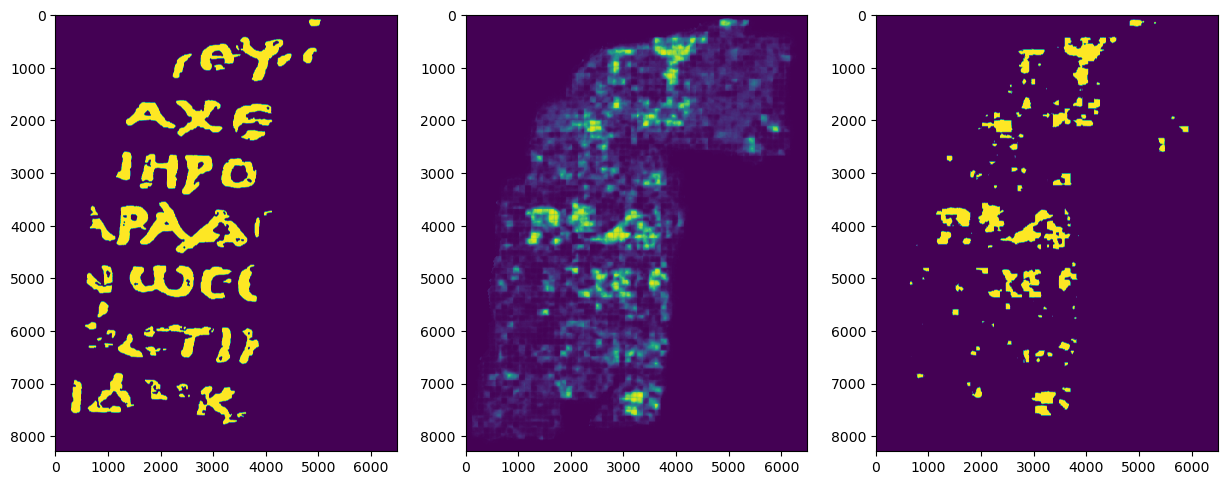

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([3.5923169e+07, 6.4540720e+06, 3.9292620e+06, 1.7428980e+06,
        1.1376180e+06, 8.3434200e+05, 6.1840600e+05, 4.8883800e+05,
        4.0715200e+05, 3.5267800e+05, 2.8978100e+05, 2.4507900e+05,
        2.2833100e+05, 2.2056100e+05, 2.1062800e+05, 2.1019700e+05,
        1.9575400e+05, 1.8946300e+05, 1.4195200e+05, 1.8667000e+04]),
 array([3.03229799e-05, 4.48579906e-02, 8.96856583e-02, 1.34513326e-01,
        1.79340994e-01, 2.24168661e-01, 2.68996329e-01, 3.13823997e-01,
        3.58651664e-01, 4.03479332e-01, 4.48307000e-01, 4.93134667e-01,
        5.37962335e-01, 5.82790003e-01, 6.27617670e-01, 6.72445338e-01,
        7.17273006e-01, 7.62100673e-01, 8.06928341e-01, 8.51756009e-01,
        8.96583676e-01]),
 <BarContainer object of 20 artists>)

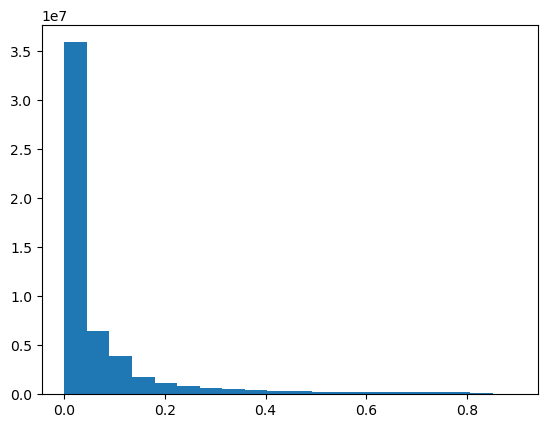

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000